# Feature engineering with Pandas

## Импорты 

In [1]:
import yaml

with open('../config.yaml', 'r') as f:
    cfg = yaml.safe_load(f)

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:

# from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
# from xgboost import XGBRegressor

### Общая информация

In [4]:
train_df = pd.read_csv(cfg['house_pricing']['train_dataset'])
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test_df = pd.read_csv(cfg['house_pricing']['test_dataset'])
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Не все столбцы здесь выведены. Их список мы можем получить, используя аттрибут `columns`:

In [6]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Почистим данные в нескольких столбцах, основываясь на data_description

In [7]:
train_df["Exterior2nd"] = train_df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
train_df["GarageYrBlt"] = train_df["GarageYrBlt"].where(train_df.GarageYrBlt <= 2010, train_df.YearBuilt)
    # Names beginning with numbers are awkward to work with
train_df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
        }, inplace=True,)

In [8]:
cat_df = train_df.select_dtypes(include=['object'])

In [9]:
num_df = train_df.select_dtypes(exclude=['object'])


## Коррелирующие признаки

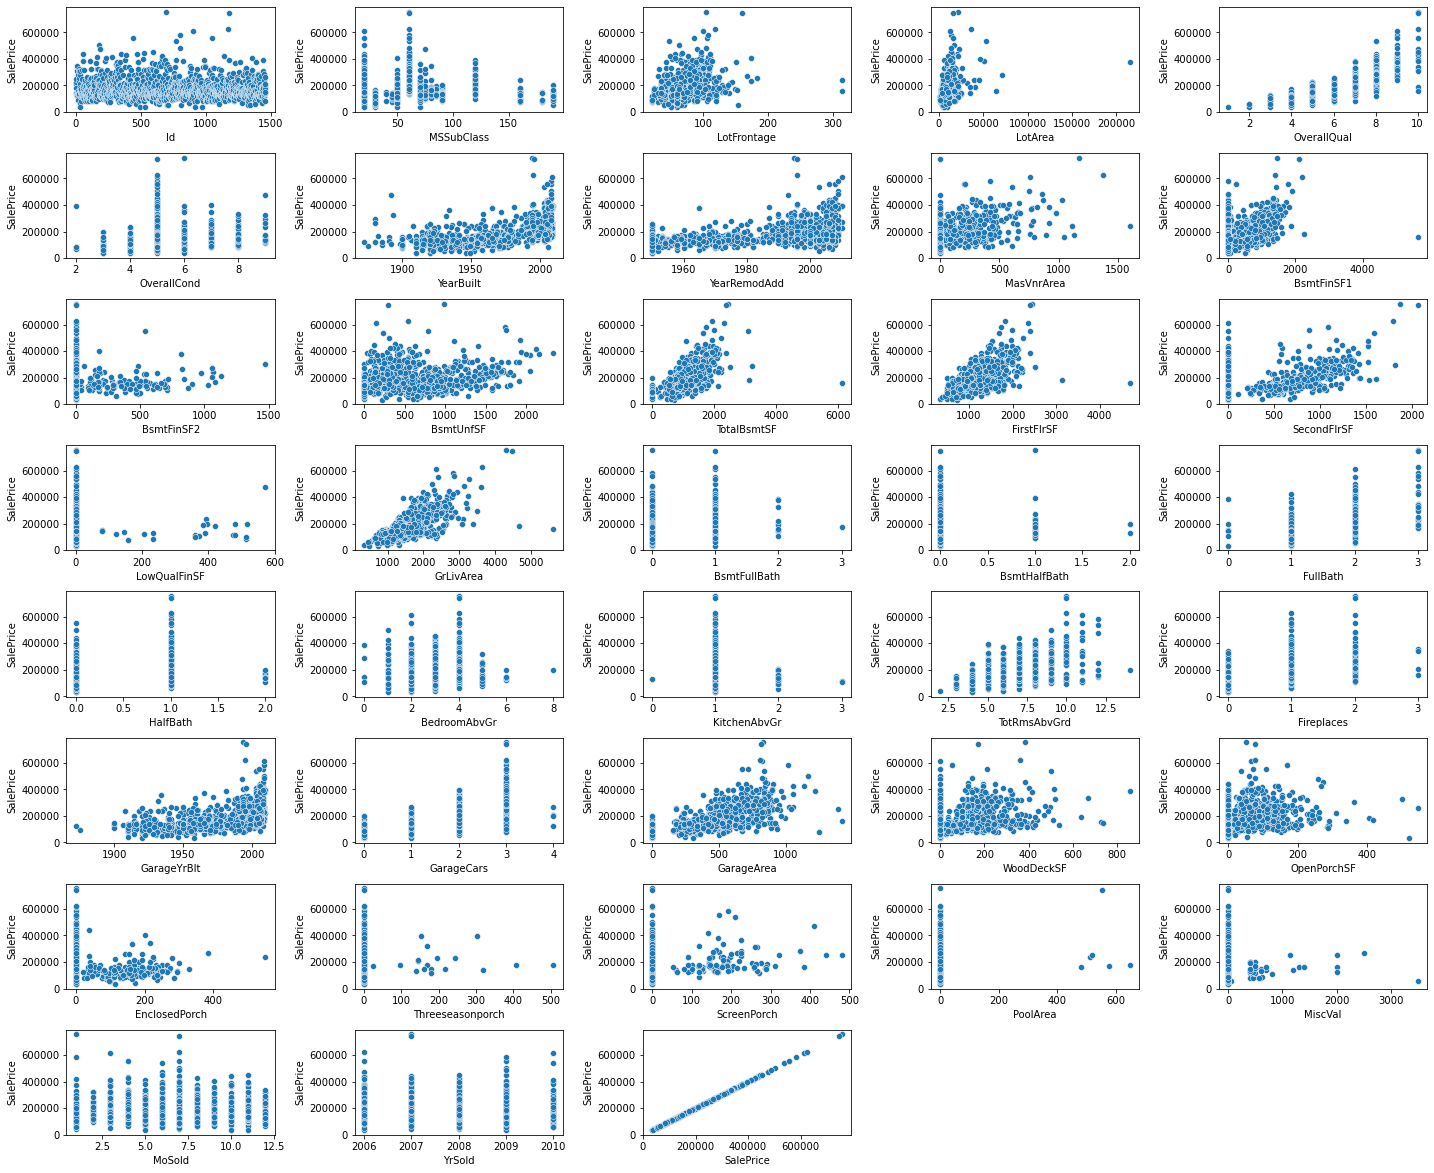

In [10]:
fig = plt.figure(figsize=(20,20))
for index in range(len(num_df.columns)):
    plt.subplot(10,5,index+1)
    sns.scatterplot(x=num_df.iloc[:,index], y='SalePrice', data=num_df.dropna())
fig.tight_layout(pad=1.0)

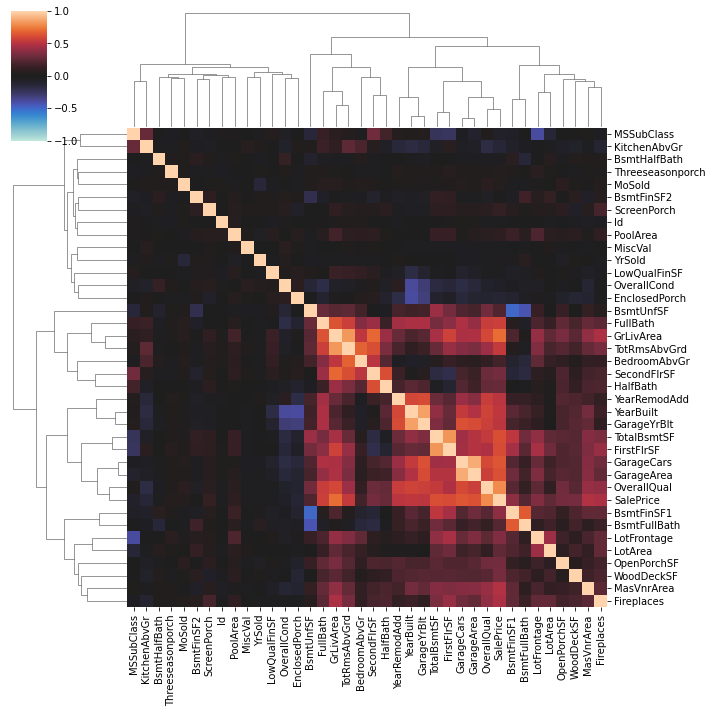

In [11]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(num_df, annot=None)

Из этой матрицы можно увидеть, какие столбцы сильно коррелируют между собой, например:
1. GarageYrBlt и YearBuilt
2. TotRmsAbvGrd и GrLivArea
3. FirstFlrSF и TotalBsmtSF
4. GarageArea и GarageCars

In [12]:
train_df.drop(['GarageYrBlt','TotRmsAbvGrd','FirstFlrSF','GarageCars'], axis=1, inplace=True)

## Заполнение пустых значений

Может быть множество вариантов, при которых строка может содержать пустые значения. Например:
1. Дом с 2 спальнями не может включать ответ на вопрос, насколько велика третья спальня
2. Кто-то из опрошенных может не делиться своим доходом
Библиотеки Python представляют недостающие числа как nan, что является сокращением от "not a number".  Какие ячейки имеют недостающие значения, можно определить с помощью команды:

In [13]:
nan_df = ((train_df.isnull().sum()) / len(train_df) *100 ).reset_index()

In [14]:
nan_df.columns=["column_name", "percentage"]

In [15]:
nan_df.sort_values("percentage", ascending=False, inplace=True)

In [16]:
nan_df[:10]

,column_name,percentage
68,PoolQC,99.520548
70,MiscFeature,96.301370
6,Alley,93.767123
69,Fence,80.753425
55,FireplaceQu,47.260274
3,LotFrontage,17.739726
56,GarageType,5.547945
57,GarageFinish,5.547945
59,GarageQual,5.547945
60,GarageCond,5.547945


In [17]:
print(f"Number of columns with more than 80% NANs: {len(nan_df[nan_df.percentage > 80])}")
print(f"Number of columns with more than 50% NANs: {len(nan_df[nan_df.percentage > 50])}")
print(f"Number of columns with more than 20% NANs: {len(nan_df[nan_df.percentage > 20])}")
print(f"Number of columns with more than 5% NANs: {len(nan_df[nan_df.percentage > 5])}")

Number of columns with more than 80% NANs: 4
Number of columns with more than 50% NANs: 4
Number of columns with more than 20% NANs: 5
Number of columns with more than 5% NANs: 10


In [18]:
nan_columns = list(nan_df[nan_df.percentage > 80]['column_name'])

1 опция: выбросить столбцы с NANам

In [19]:
# 1 вариант - если, например, нужно выбросить одинаковые столбцы для обучающей и тестовой выборок
num_сols_with_missing = [col for col in num_df.columns 
                                 if num_df[col].isnull().any()]



In [20]:
num_df_dropped = num_df.drop(num_сols_with_missing, axis=1)

In [21]:
# 2 вариант - если нужно просто выбросить NANы
num_df_dropped = num_df.dropna(axis=1)

Если эти столбцы содержат полезную информацию (в местах, которые не были пропущены), модель теряет доступ к этой информации при удалении столбца. Кроме того, если тестовые данные имеют отсутствующие значения в тех местах, где тренировочные не имели, это приведет к ошибке.

Так что обычно это не лучшее решение. Однако оно может быть полезно, когда большинство значений в столбце отсутствуют.

Заполним недостающие значения каким-то числом. Это значение будет не совсем правильным в большинстве случаев, но обычно оно дает более точные модели, чем полное удаление столбца.

Поведение по умолчанию заполняет столбец средним значением в заполненных ячейках. уществуют и более сложные стратегии, но эти сложные стратегии.

In [22]:
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()

train_df[num_сols_with_missing] = my_imputer.fit_transform(train_df[num_сols_with_missing])

In [23]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Альтернативно можно заполнить столбцы средним напрямую (или нулями, или чем угодно)

In [24]:
train_df[num_сols_with_missing] = train_df[num_сols_with_missing].fillna(train_df[num_сols_with_missing].mean())

Те столбцы, которые содержали более 80% NANов, удалим совсем

In [25]:
train_df.drop(nan_columns, inplace=True, axis=1)

Категориальные признаки заполним наиболее часто встречающимся значением

In [26]:
cols = ["MasVnrType", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "Functional"]
for col in cols:
    print(f"Mode of column {col} is {train_df[col].dropna().mode()[0]}")
train_df[cols] = train_df.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.dropna().mode()[0]))

Mode of column MasVnrType is None
Mode of column MSZoning is RL
Mode of column Exterior1st is VinylSd
Mode of column Exterior2nd is VinylSd
Mode of column SaleType is WD
Mode of column Electrical is SBrkr
Mode of column Functional is Typ


Порядковые признаки невозможно заполнить средним или часто встречающимся, так что для начала заполним их значением по умолчанию "NA"

In [27]:
cat = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1', 
       'GarageCond','GarageQual','BsmtCond','BsmtQual','FireplaceQu',"KitchenQual",
       "HeatingQC",'ExterQual','ExterCond']

train_df[cat] = train_df[cat].fillna("NA")

<AxesSubplot:xlabel='Neighborhood', ylabel='GarageArea_mean'>

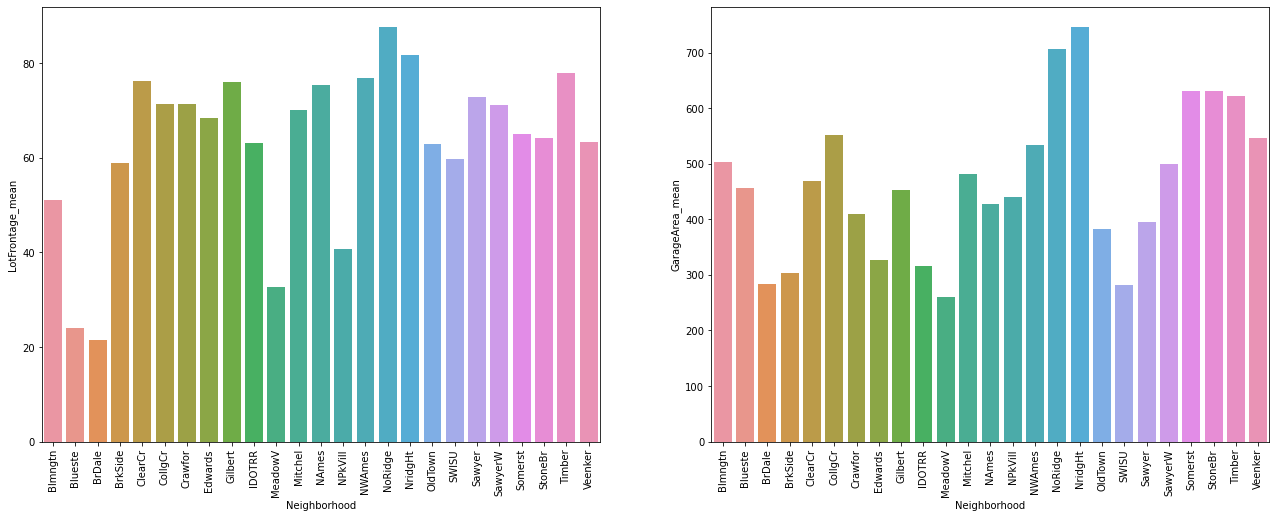

In [28]:
neigh_lot = train_df.groupby('Neighborhood')['LotFrontage'].mean().reset_index(name='LotFrontage_mean')
neigh_garage = train_df.groupby('Neighborhood')['GarageArea'].mean().reset_index(name='GarageArea_mean')

fig, axes = plt.subplots(1,2,figsize=(22,8))
axes[0].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='LotFrontage_mean', data=neigh_lot, ax=axes[0])
axes[1].tick_params(axis='x', rotation=90)
sns.barplot(x='Neighborhood', y='GarageArea_mean', data=neigh_garage, ax=axes[1])

In [29]:
#for correlated relationship
train_df['LotFrontage'] = train_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
train_df['GarageArea'] = train_df.groupby('Neighborhood')['GarageArea'].transform(lambda x: x.fillna(x.mean()))
train_df['MSZoning'] = train_df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))


MSSubClass - это столбец с числовым признаком, который на самом деле можно представить как категориальный

In [30]:
train_df['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [31]:
train_df['MSSubClass'] = train_df['MSSubClass'].apply(str)

In [32]:
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}

In [33]:
ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
for col in ord_col:
    train_df[col] = train_df[col].map(ordinal_map)
    
fin_col = ['BsmtFinType1','BsmtFinType2']
for col in fin_col:
    train_df[col] = train_df[col].map(fintype_map)

train_df['BsmtExposure'] = train_df['BsmtExposure'].map(expose_map)

## Удаление признаков, которые в основном имеют всего 1 значение
Некоторые признаки в основном состоят из одного значения или нулей, что не особо полезно для нас. Поэтому мы устанавливаем пороговое значение, определяемое пользователем, на уровне 96%. Если столбец имеет более 96% от одного и того же значения, мы считаем признак бесполезными и удалим его.

In [34]:
overfit_cat = []
cat_df = train_df.select_dtypes(include=['object'])
for i in cat_df:
    counts = train_df[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train_df) * 100 > 96:
        overfit_cat.append(i)

overfit_cat = list(overfit_cat)
train_df = train_df.drop(overfit_cat, axis=1)

In [35]:
num_col = train_df.select_dtypes(exclude=['object'])
overfit_num = []
for i in num_col:
    counts = train_df[i].dropna().value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train_df) * 100 > 96:
        overfit_num.append(i)

overfit_num = list(overfit_num)
train_df = train_df.drop(overfit_num, axis=1)

In [36]:
print("Categorical Features with >96% of the same value: ", overfit_cat)
print("Numerical Features with >96% of the same value: ",overfit_num)

Categorical Features with >96% of the same value:  ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']
Numerical Features with >96% of the same value:  ['LowQualFinSF', 'Threeseasonporch', 'PoolArea', 'MiscVal']


Другой способ - использовать метод VarianceThreshold от sklearn — это простой базовый подход к выбору признаков. Он удаляет все признаки, дисперсия которых не соответствует определенному порогу. По умолчанию он удаляет все элементы с нулевой дисперсией, т.е. те элементы, которые имеют одинаковое значение у всех семплов.

In [38]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.1)
num_col = train_df.select_dtypes(exclude=['object'])

sel.fit(num_col)  # fit finds the features with zero variance
sum(sel.get_support())

39

In [39]:
sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [40]:
print(
    len([
        x for x in num_col.columns
        if x not in num_col.columns[sel.get_support()]
    ]))

[x for x in num_col.columns if x not in num_col.columns[sel.get_support()]]

2


['BsmtHalfBath', 'KitchenAbvGr']

Удаление выбросов предотвратит воздействие экстремальных значений на производительность наших моделей.
Из нашего боксплота ранее, мы выделили следующие особенности с экстремальными выбросами:

* LotFrontage
* LotArea
* smtFinSF1
* TotalBsmtSF
* GrLivArea

Мы уберем выбросы на основе определенного порогового значения.

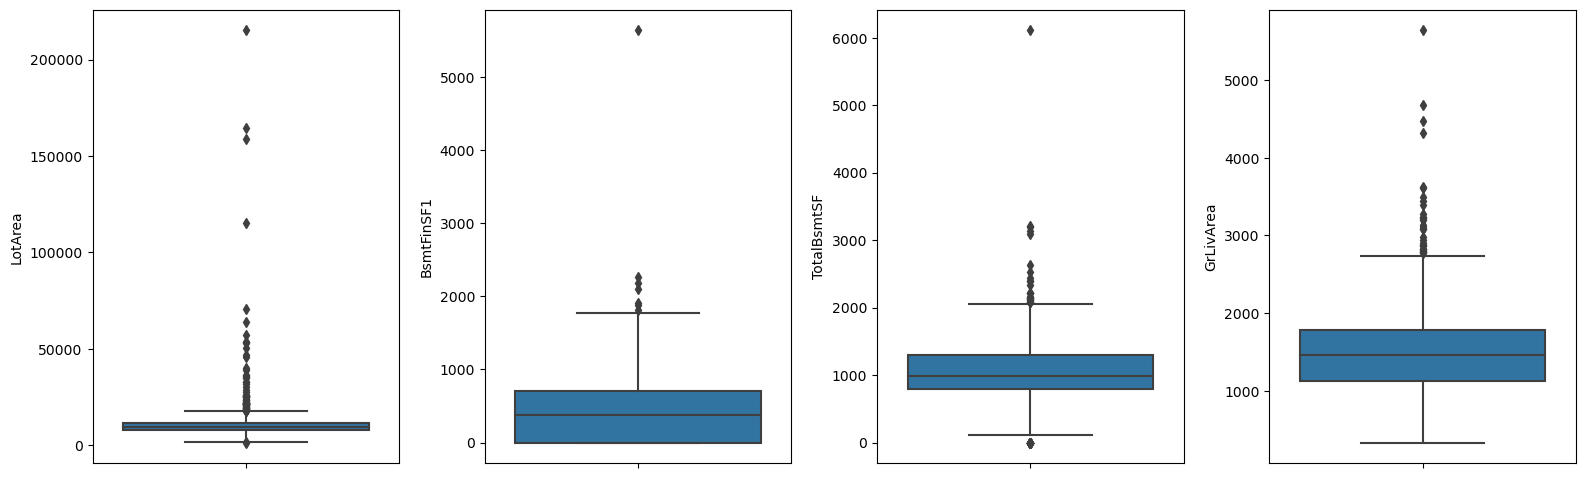

In [259]:
# out_col = ['LotFrontage','LotArea','BsmtFinSF1','TotalBsmtSF','GrLivArea']
out_col = ['LotArea','BsmtFinSF1','TotalBsmtSF','GrLivArea']

fig = plt.figure(figsize=(20,5))
for index,col in enumerate(out_col):
    plt.subplot(1,5,index+1)
    
    sns.boxplot(y=train_df[col], data=train_df)
fig.tight_layout(pad=1.5)

In [260]:
train_df = train_df.drop(train_df[train_df['LotFrontage'] > 200].index)
train_df = train_df.drop(train_df[train_df['LotArea'] > 100000].index)
train_df = train_df.drop(train_df[train_df['BsmtFinSF1'] > 4000].index)
train_df = train_df.drop(train_df[train_df['TotalBsmtSF'] > 5000].index)
train_df = train_df.drop(train_df[train_df['GrLivArea'] > 4000].index)

После удаления выбросов, сильно коррелированных признаков и условных отсутствующих значений мы можем приступить к добавлению дополнительной информации для обучения нашей модели. Это делается с помощью - Feature Engineering.

## Feature Engineering

Feature Engineering - это техника, с помощью которой мы создаем новые признаки, которые потенциально могут помочь в прогнозировании нашей целевой переменной, которая в данном случае является SalePrice. 

Основываясь на текущих признаках, мы можем добавить первый дополнительный признак, который будет называться TotalLot и который суммирует LotFrontage и LotArea для определения общей площади земли, доступной в виде лота. Мы также можем рассчитать общее количество площади поверхности дома, TotalSF, сложив площадь от 1-го этажа и 2-го этажа. TotalBath также может быть использован, чтобы сказать нам в общей сложности, сколько ванных комнат есть в доме. Мы также можем добавить все различные типы крыльц вокруг дома и обобщить в общей площади крыльца, TotalPorch.

* TotalLot = LotFrontage + LotArea
* TotalSF = TotalBsmtSF + 2ndFlrSF
* TotalBath = FullBath + HalfBath
* TotalPorch = OpenPorchSF + EnclosedPorch + ScreenPorch
* TotalBsmtFin = BsmtFinSF1 + BsmtFinSF2

In [261]:
train_df['TotalLot'] = train_df['LotFrontage'] + train_df['LotArea']
train_df['TotalBsmtFin'] = train_df['BsmtFinSF1'] + train_df['BsmtFinSF2']
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['SecondFlrSF']
train_df['TotalBath'] = train_df['FullBath'] + train_df['HalfBath']
train_df['TotalPorch'] = train_df['OpenPorchSF'] + train_df['EnclosedPorch'] + train_df['ScreenPorch']

In [262]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       'CentralAir', 'Electrical', 'SecondFlrSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MoSold',
       'YrSold', 'SaleType', 'SaleCondition', 'SalePrice', 'TotalLot',
       '

In [263]:
train_df["LivLotRatio"] = train_df["GrLivArea"] / train_df["LotArea"]

Мы также включаем создание бинарных столбцов для некоторых признаков, которые могут указывать на наличие(1) / отсутствие(0) некоторых признаков дома

In [264]:
cols = ['MasVnrArea','TotalBsmtFin','TotalBsmtSF','SecondFlrSF','WoodDeckSF','TotalPorch']

for col in cols:
    col_name = col+'_bin'
    train_df[col_name] = train_df[col].apply(lambda train_df: 1 if train_df > 0 else 0)

Наконец, поскольку нам нужны данные, которые носят численный характер, мы преобразуем оставшиеся категориальные столбцы с помощью one-hot-encoding с помощью метода get_dummies() в числовые столбцы, которые подходят для подачи в наш алгоритм машинного обучения.

In [265]:
train_df = pd.get_dummies(train_df)

In [266]:
len(train_df.columns)

226

In [267]:
train_df.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450,7,5,2003,2003,196.0,4,3,...,0,0,0,1,0,0,0,0,1,0
1,2,80.0,9600,6,8,1976,1976,0.0,3,3,...,0,0,0,1,0,0,0,0,1,0
2,3,68.0,11250,7,5,2001,2002,162.0,4,3,...,0,0,0,1,0,0,0,0,1,0
3,4,60.0,9550,7,5,1915,1970,0.0,3,3,...,0,0,0,1,1,0,0,0,0,0
4,5,84.0,14260,8,5,2000,2000,350.0,4,3,...,0,0,0,1,0,0,0,0,1,0


## Кластеринг

Для создания новых признаков можно использовать обучение без учителя, например, кластеризацию с помощью k средних. Можно использовать как категорию (столбец с 0, 1, 2,...) метки кластеров или расстояние наблюдений до каждого кластера. Эти особенности иногда могут быть эффективными при распутывании сложных пространственных отношений.

In [268]:
cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "SecondFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

In [269]:
cluster_df = cluster_labels(train_df, features=cluster_features)


D:\Anaconda\envs\students\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [270]:
cluster_df.head()

,Cluster
0,16
1,19
2,16
3,16
4,11


In [273]:
train_df['cluster_num'] = cluster_df["Cluster"]

227

## Скейлинг
RobustScaler - это метод преобразования, который удаляет медиану и масштабирует данные в соответствии с диапазоном квантиля (по умолчанию IQR: межквартильный диапазон). IQR - это диапазон между 1-м квартилем (25-й квантилем) и 3 Квартиль (75-й квантиль). Он также устойчив к выпадающим значениям, что делает его идеальным для данных, где слишком много выпадающих значений, что резко сократит количество обучающих данных.

Запуская скейлер как на тренировочном, так и на тестовом наборах, мы подвергаем себя проблеме утечки данных. Утечка данных - это проблема, когда для создания модели используется информация извне набора для обучения. Если мы подгоняем скейлер как на тренировочные, так и на тестовые данные, наши характеристики тренировочных данных будут содержать распределение нашего тестового набора. Таким образом, мы неявно передаем информацию о наших тестовых данных в окончательные тренировочные данные для обучения, что не даст нам возможности по-настоящему протестировать нашу модель на данных, которые она никогда не видела.

*Извлеченные уроки:* Установка скалера только на обучающие данные, а затем преобразование данных как обучающей, так и тестовой выборок

In [284]:
from sklearn.preprocessing import RobustScaler

cols = train_df.select_dtypes(np.number).columns
train_df = train_df.drop(["Id"], axis=1)
transformer = RobustScaler().fit(train_df[cols])
train_df[cols] = transformer.transform(train_df[cols])

KeyError: "['Id'] not in index"

Таким образом, мы сильно преобразовали наш обучающий набор. кроме перчисленного, полезно использовать PCA, выбор признаков на основе информации и други методы. Как вы, наверное, заметили, все преобразования были сделаны только для тренировочного набора, но то же самое необходимо сделать и для тестового.

Чтобы предотвратить утечку данных, все преобразования по среднему и тп нужно сделать независимо, а если мы, например, кодировали или удаляли столбцы, нужно сделать такое же преобразование, используя старые правила. 

После того, как это было сделано, можно передавать данные в модель.

In [285]:
train_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,cluster_num
0,-0.265787,-0.251222,0.5,0.0,0.652174,0.270270,1.206154,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6
1,0.523686,0.037107,0.0,3.0,0.065217,-0.459459,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9
2,-0.107893,0.450796,0.5,0.0,0.608696,0.243243,0.996923,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6
3,-0.528945,0.024571,0.5,0.0,-1.260870,-0.621622,0.000000,0.0,0.0,-1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.6
4,0.734213,1.205466,1.0,0.0,0.586957,0.189189,2.153846,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
